 **<H1>PREDICTING ZOMATO RESTAURANTS RATE</H1>**

**<h2>1.Business Problem</h2>**

**1.1 Problem Description**

Restaurants from all over the world can be found here in Bengaluru. From United States to Japan, Russia to Antarctica, you get all type of cuisines here. Delivery, Dine-out, Pubs, Bars, Drinks,Buffet, Desserts you name it and Bengaluru has it. Bengaluru is best place for foodies. The number of restaurant are increasing day by day. Currently which stands at approximately 12,000 restaurants. With such an high number of restaurants. This industry hasn't been saturated yet. And new restaurants are opening every day. However it has become difficult for them to compete with already established restaurants. The key issues that continue to pose a challenge to them include high real estate costs, rising food costs, shortage of quality manpower, fragmented supply chain and over-licensing. 

**1.2 Problem Statement**

The dataset also contains reviews for each of the restaurant which will help in finding overall rating for the place. So we will try to predict rating for particular restaurant.

**1.3 Machine Learning Formulation**

Here we suppose to predicted rating of restaurant, so it is basically Regression problem.


**1.4 Perfomance Metric**

We will try to reduce Mean Square Error ie MSE as minimum as possible. So it is Regression problem reducing MSE. And Ideal MSE is 0


**<H2>2. Machine Learning Problem</H2>**

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('dark_background')
import re
import tqdm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import  hstack,vstack
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV, train_test_split


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/my code/zomato.csv")

In [ ]:
dataset.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
dataset.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [ ]:
dataset.shape

(51717, 17)

In [ ]:
dataset.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [ ]:
dataset.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

**Data Cleaning**

In [ ]:
#lets remove the columns which are useless and dont contribute much to targets
dataset=dataset.drop(['url','name','address','phone','menu_item','dish_liked'],axis=1)

In [ ]:
#lets rename some of the column  names to make it easy to understand
dataset=dataset.rename({'approx_cost(for two people)':'avg_2_ppl_cost','listed_in(type)':'listed_type','listed_in(city)':'listed_in_city'},axis=1)

In [ ]:
dataset.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,avg_2_ppl_cost,reviews_list,listed_type,listed_in_city
0,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,Banashankari
1,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,Banashankari
2,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,Banashankari
3,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,Banashankari
4,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,Banashankari


In [ ]:
dataset.nunique()

online_order          2
book_table            2
rate                 64
votes              2328
location             93
rest_type            93
cuisines           2723
avg_2_ppl_cost       70
reviews_list      22513
listed_type           7
listed_in_city       30
dtype: int64

In [ ]:
dataset.shape

(51717, 11)

In [ ]:
# Dropping duplicates.

print('Number of Dublicate values in Data Frame = ',dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

Number of Dublicate values in Data Frame =  219


In [ ]:
dataset.shape

(51498, 11)

In [ ]:
#finding features which has null values
nul_features= [x for x in dataset.columns if dataset[x].isnull().sum()>0]
nul_features

['rate', 'location', 'rest_type', 'cuisines', 'avg_2_ppl_cost']

In [ ]:
#lets find %of null values in above features

for x in nul_features:
    print('{} has {} % missing values'.format(x,np.round(dataset[x].isnull().sum()/len(dataset)*100,4)))



rate has 14.7909 % missing values
location has 0.0369 % missing values
rest_type has 0.4369 % missing values
cuisines has 0.0835 % missing values
avg_2_ppl_cost has 0.6641 % missing values


These are the percentages of missing values in specified columns.

1. Rate column have 14.7909% of missing values it is more as compare to others.
2. location has 0.0369 % missing values
3. rest_type has 0.4389 % missing values
4. cuisines has 0.0835 % missing values
5. avg_2_ppl_cost has 0.6641 % missing values



**Analysing Each Columns**

In [ ]:
#replacing online_order and table_book with binary feature
dataset['online_order'].replace({'Yes':1,'No':0},inplace = True)
dataset['book_table'].replace({'Yes':1,'No':0},inplace = True)


In [ ]:
dataset['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [ ]:
dataset.shape

(24888, 11)

In [ ]:
#removing '/5' from rate column
def split(x):
  return x.split('/')[0]



In [ ]:
dataset['rate']=dataset['rate'].astype(str)
dataset['rate']=dataset['rate'].apply(split)
dataset['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: object

In [ ]:
dataset['rate'].unique()

array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', 'NEW', '2.9', '3.5',
       'nan', '2.6', '3.8 ', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4',
       '2.2', '2.3', '3.4 ', '-', '3.6 ', '4.8', '3.9 ', '4.2 ', '4.0 ',
       '4.1 ', '3.7 ', '3.1 ', '2.9 ', '3.3 ', '2.8 ', '3.5 ', '2.7 ',
       '2.5 ', '3.2 ', '2.6 ', '4.5 ', '4.3 ', '4.4 ', '4.9', '2.1',
       '2.0', '1.8', '4.6 ', '4.9 ', '3.0 ', '4.8 ', '2.3 ', '4.7 ',
       '2.4 ', '2.1 ', '2.2 ', '2.0 ', '1.8 '], dtype=object)

So rate column looks better now. Let's remove 'NEW' and '-' and make it look more clean.

In [ ]:
dataset.replace('NEW',0,inplace = True)

In [ ]:
dataset.replace('-',0,inplace = True)

In [ ]:
#change datatype of rate column from object to float

dataset['rate']=dataset['rate'].astype(float)

In [ ]:
dataset['rate'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 0. , 2.9, 3.5, nan, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4,
       2.2, 2.3, 4.8, 4.9, 2.1, 2. , 1.8])

In [ ]:
#sum of null values in rate column
dataset['rate'].isnull().sum()

7617

In [ ]:
#filling null values of rate with mean in rate column

dataset['rate'].fillna(dataset['rate'].mean(),inplace=True)

dataset['rate'].isnull().sum()

0

In [ ]:
#We have location and city, so to make it clear removing city column
dataset.drop(['listed_in_city'],axis=1,inplace=True)

In [ ]:
# avg_2_ppl_Cost column is in object data type we need to convert it to int
dataset['avg_2_ppl_cost'] = dataset['avg_2_ppl_cost'].astype(str)
dataset['avg_2_ppl_cost'] = dataset['avg_2_ppl_cost'].apply(lambda x: x.replace(',','.'))
dataset['avg_2_ppl_cost'] = dataset['avg_2_ppl_cost'].astype(float)

In [ ]:
dataset.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,avg_2_ppl_cost,reviews_list,listed_type
0,1,1,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet
1,1,0,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet
2,1,0,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet
3,0,0,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet
4,0,0,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet


In [ ]:
#lets add another column  with number of cuisines 
def count_cuisines(x):
  num_cuisine = len(str(x).split(','))
  return num_cuisine

In [ ]:
#This will be new feature in the data, we can explore this later
dataset['cuisine_count']=dataset['cuisines'].apply(count_cuisines)
dataset.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,avg_2_ppl_cost,reviews_list,listed_type,cuisine_count
0,1,1,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Buffet,3
1,1,0,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",Buffet,3
2,1,0,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Buffet,3
3,0,0,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",Buffet,2
4,0,0,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Buffet,2


In [ ]:
#dropping null values from whole dataset

dataset.dropna(inplace=True)
dataset.shape

(50933, 11)

In [ ]:
dataset.isnull().sum()

online_order      0
book_table        0
rate              0
votes             0
location          0
rest_type         0
cuisines          0
avg_2_ppl_cost    0
reviews_list      0
listed_type       0
cuisine_count     0
dtype: int64

**Visualization**

Text(0.5, 1.0, 'Restaurants that take online_order')

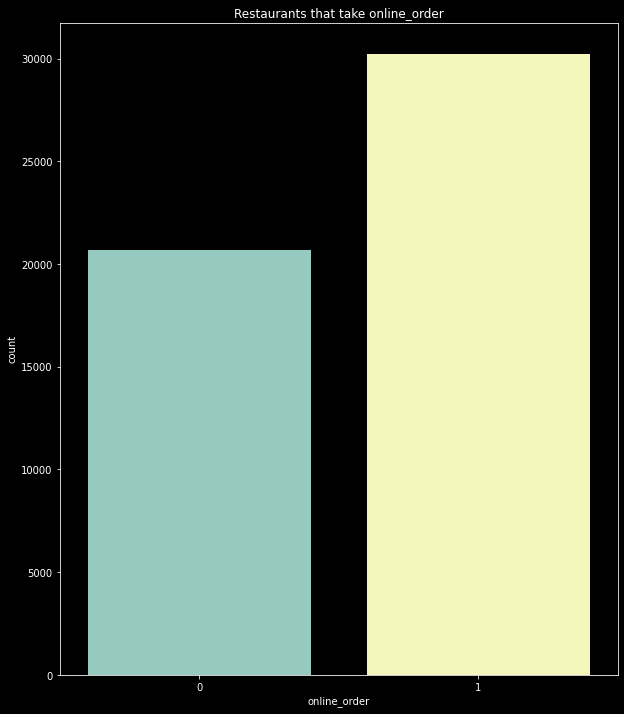

In [ ]:
plt.figure(figsize=(10,12))
sns.countplot(dataset["online_order"])
plt.title("Restaurants that take online_order")

* The number of restaurants that take Online orders are more compared to that of restaurants which dont have online facility.

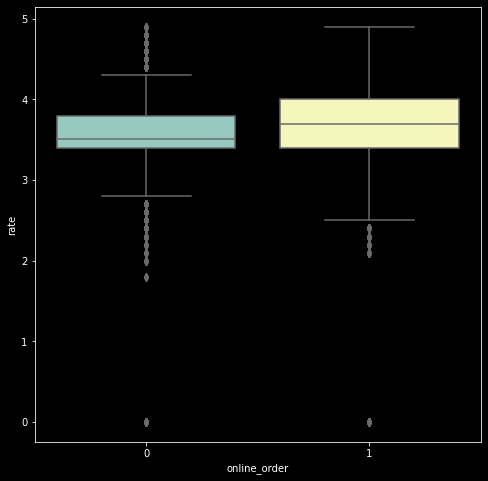

In [ ]:
#online_order vs rating
plt.figure(figsize=(8,8))
sns.boxplot(x='online_order', y='rate',data=dataset)

The restaurants which have online order facility has more ratings

Text(0.5, 1.0, 'Types of Restaurants')

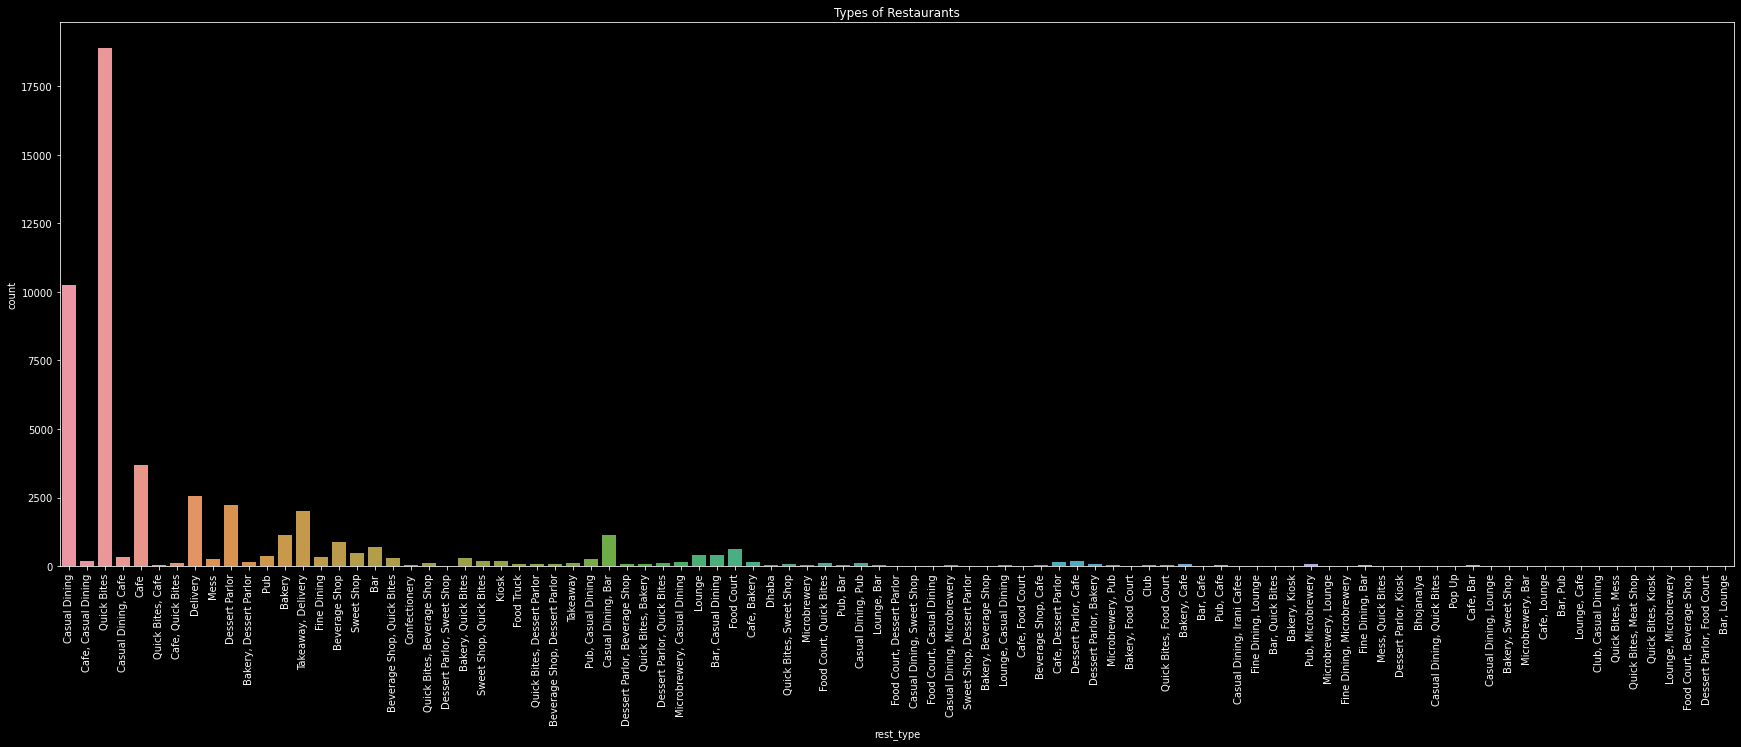

In [ ]:

dataset.location.value_counts()
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.countplot("rest_type",data=dataset)
plt.title("Types of Restaurants")

Bangalore has very much large number of casual dining, quick bites and cafe's type of restaurants as compared to others

Text(0.5, 1.0, 'Restaurants In which tables are booked')

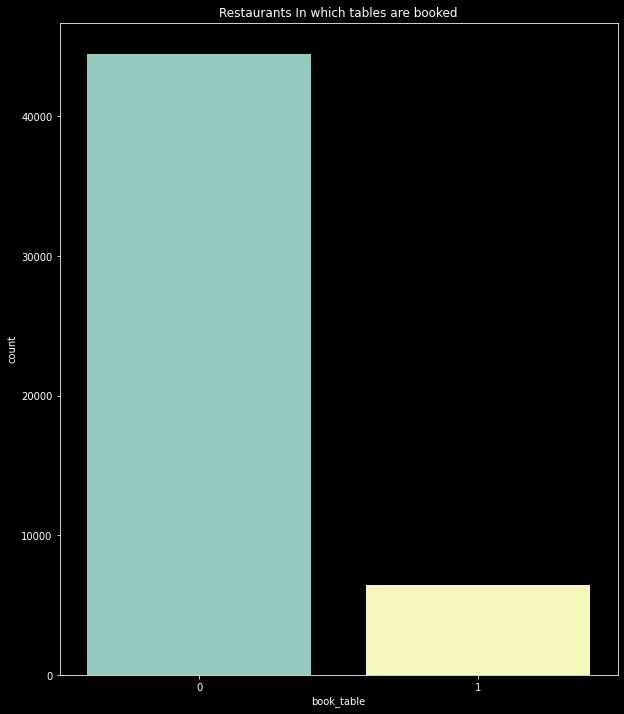

In [ ]:
plt.figure(figsize=(10,12))
sns.countplot(dataset["book_table"])
plt.title("Restaurants In which tables are booked")

The number of restaurants that has facility of table_booking is very less.

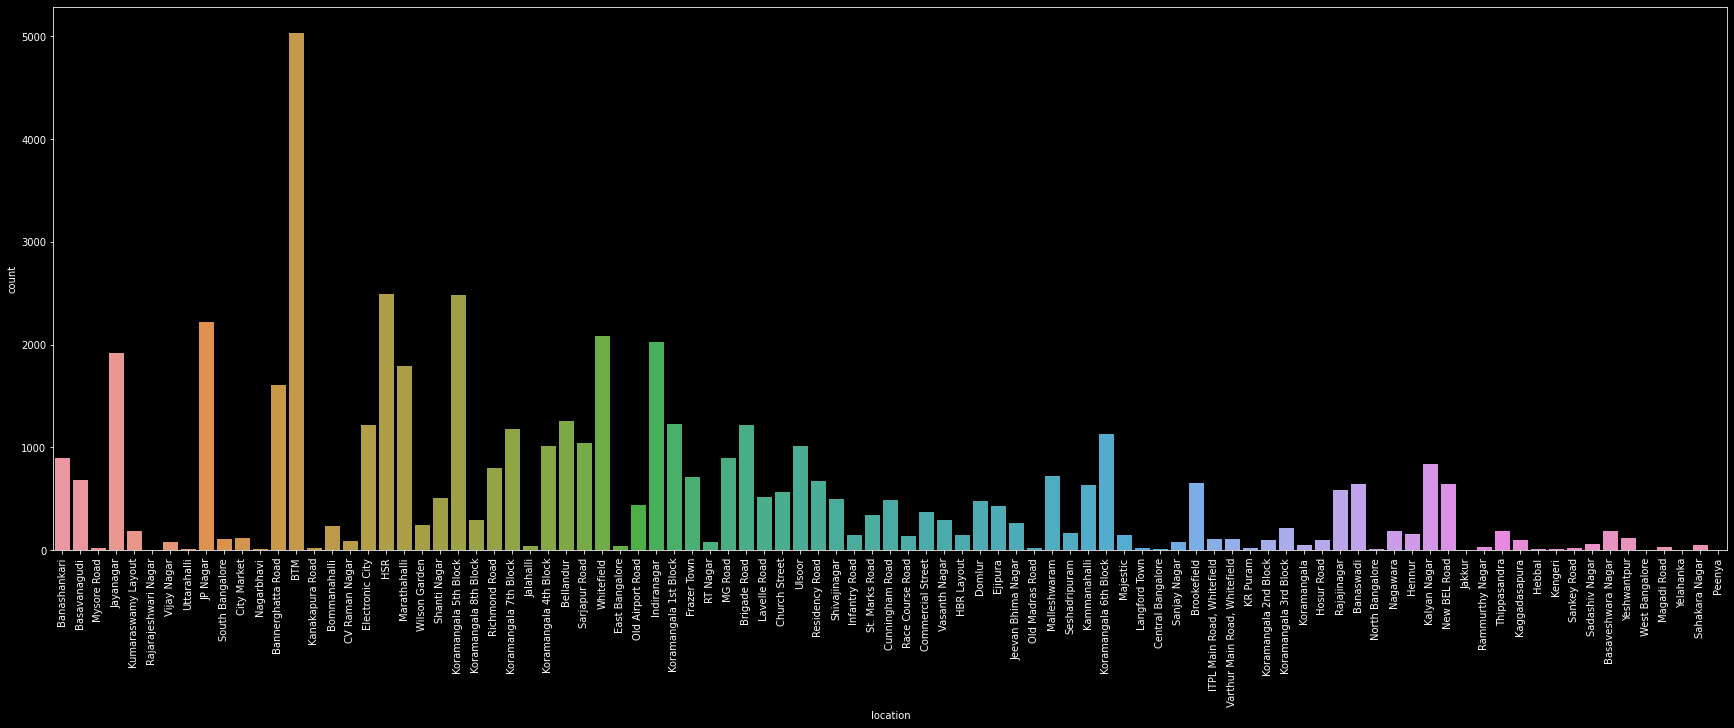

In [ ]:

plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.countplot('location',data=dataset)

BTM Layout has heighest restaurants and next is HSR layout

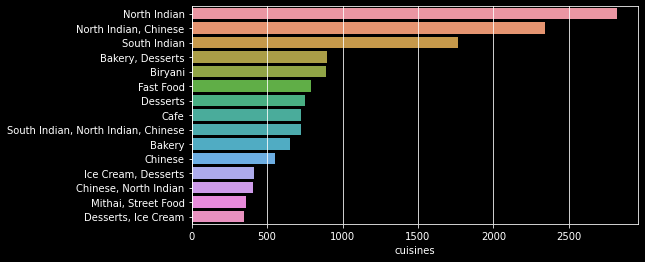

In [ ]:
Cuisine = dataset['cuisines'].value_counts()[:15] # top 15 cuisines
plt.figure(figsize=(8,4))
plt.grid(True)
sns.barplot(Cuisine,Cuisine.index)

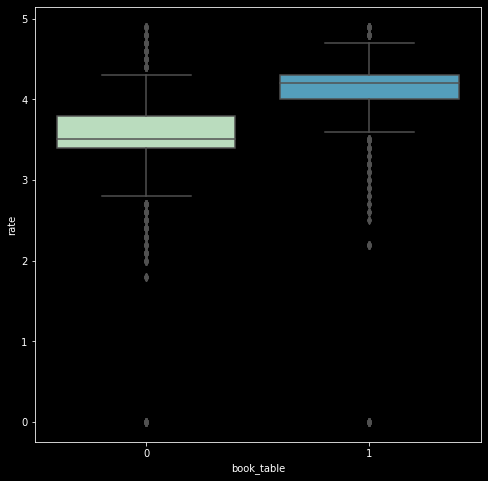

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x='book_table',data=dataset,y='rate',palette='GnBu')

Ratings given when table booked are heigh when compared to other ratings given by when tables were not booked

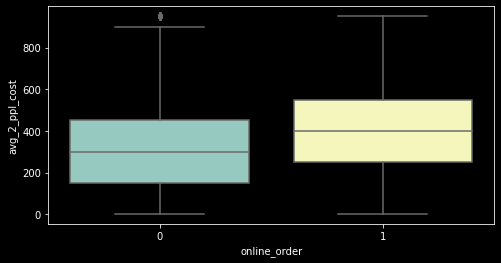

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='online_order',y='avg_2_ppl_cost',data=dataset)

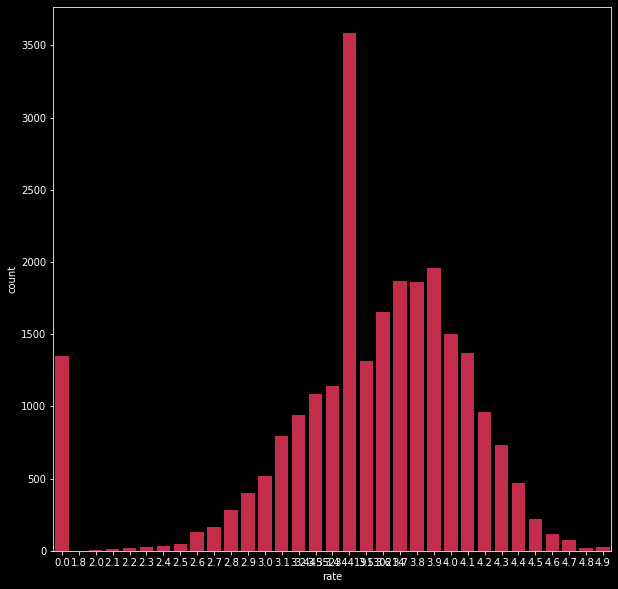

In [ ]:
plt.figure(figsize = (10, 10))
sns.countplot(dataset['rate'], color = 'crimson')

**<h1>Preprocessing the reviews column</h1>**

In [ ]:
dataset['reviews_list'].shape

(50933,)

In [ ]:
dataset['reviews_list'].dropna(inplace=True)
dataset['reviews_list'].shape

(50933,)

In [ ]:
#changing the review data tyoe from object to string
dataset['reviews_list']=dataset['reviews_list'].astype("str")


In [ ]:

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"Rated", "", phrase)
    phrase = re.sub(r"RATED", "", phrase)
   
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","rated", "\n", "n","nan", "x"])



In [ ]:
from tqdm import tqdm

# tqdm is for printing the status bar
def preprocessed_data(text):
  preprocessed_text= []
  for sentance in tqdm(text):
    
    sentance = re.sub(r"http\S+", "", sentance)
    
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_text.append(sentance.strip())
  return preprocessed_text



In [ ]:
#preprocessing each column and updating columns with preprocessed values

dataset["reviews_list"]=preprocessed_data(dataset["reviews_list"].values)
dataset["cuisines"]=preprocessed_data(dataset["cuisines"].values)
dataset["rest_type"]=preprocessed_data(dataset["rest_type"].values)
dataset["location"]=preprocessed_data(dataset["location"].values)
dataset["listed_type"]=preprocessed_data(dataset["listed_type"].values)

100%|██████████| 50933/50933 [00:01<00:00, 49867.19it/s]


In [ ]:
dataset.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,avg_2_ppl_cost,reviews_list,listed_type,cuisine_count
0,1,1,4.1,775,banashankari,casual dining,north indian mughlai chinese,800.0,beautiful place dine interiors take back mugha...,buffet,3
1,1,0,4.1,787,banashankari,casual dining,chinese north indian thai,800.0,dinner family turned good choose suitable ages...,buffet,3
2,1,0,3.8,918,banashankari,cafe casual dining,cafe mexican italian,800.0,ambience not good enough not pocket friendly c...,buffet,3
3,0,0,3.7,88,banashankari,quick bites,south indian north indian,300.0,great food proper karnataka style full meals t...,buffet,2
4,0,0,3.8,166,basavanagudi,casual dining,north indian rajasthani,600.0,good restaurant neighbourhood buffet system pr...,buffet,2


**<h1>SPLITTING THE DATA INTO TRAIN AND TEST VALUES</h1>**

In [ ]:
y= dataset["rate"].values
X=dataset.drop(["location","rate","online_order","book_table","votes","location","rest_type","cuisines","avg_2_ppl_cost","listed_type","cuisine_count"],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.20, stratify=y)

print(X_train.shape)
print(X_test.shape)

(40746, 1)
(10187, 1)


 **<h2>FEATURIZING THE REVIEW COLUMN</h2>**

In [ ]:
data1=X_train["reviews_list"].values



**AVG W2V FOR TRAIN VALUES**

In [ ]:
#lets load glove_vector
#make sure need to have the glove_vectors file
import pickle

with open("/content/drive/MyDrive/my code/glove_vectors",'rb') as f:
  model= pickle.load(f)

  glove_words=set(model.keys())

In [ ]:
avg_w2v_vectors=[]  #to store avg_w2v in list
for sentence in tqdm(data1): #for each review from preprocessed reviews
    vector=np.zeros(300)#initialising the vector with zero length
    count_word=0#initialising count_word with valid_vector in each review
    for word in sentence.split(): #each word from review
      if word in glove_words:
        vector+=model[word]
        count_word+=1
    if count_word!=0:
      vector/=count_word
    avg_w2v_vectors.append(vector)


print(type(avg_w2v_vectors))

100%|██████████| 40746/40746 [00:57<00:00, 709.50it/s]

<class 'list'>


In [ ]:
data2=X_test["reviews_list"].values



**AVG W2V FOR TEST VALUES**

In [ ]:
avg_w2v_vectors_test=[]  #to store avg_w2v in list
for sentence in tqdm(data2): #for each review from preprocessed reviews
    vector=np.zeros(300)#initialising the vector with zero length
    count_word=0#initialising count_word with valid_vector in each review
    for word in sentence.split(): #each word from review
      if word in glove_words:
        vector+=model[word]
        count_word+=1
    if count_word!=0:
      vector/=count_word
    avg_w2v_vectors_test.append(vector)
print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████| 10187/10187 [00:14<00:00, 696.12it/s]

10187
300


In [ ]:
from scipy.sparse import csr_matrix
w2v=csr_matrix(avg_w2v_vectors)
w2v_test=csr_matrix(avg_w2v_vectors_test)

print(w2v.shape)
print(w2v_test.shape)

(40746, 300)
(10187, 300)


**<h1>MODELLING</h1>**

**Modelling with all features and Avg W2V Vectorizer**

In [ ]:
#computing the  MSE for LinearRegression Model
model_1_w2v=LinearRegression()

model_1_w2v.fit(w2v,y_train)
model_1_train_pred=model_1_w2v.predict(w2v)  #Predictng for train values
model_1_test_pred=model_1_w2v.predict(w2v_test)  #predicting for test values


print("The train_MSE  for LR model",mean_squared_error(y_train,model_1_train_pred))
print("The test_MSE for LR model",mean_squared_error(y_test,model_1_test_pred))

The train_MSE  for LR model 0.6897697205256759
The test_MSE for LR model 0.6974556843828231


In [ ]:
##computing the  MSE for RandomForestRegression Model
model_2_w2v=RandomForestRegressor(n_jobs=-1)
model_2_w2v.fit(avg_w2v_vectors,y_train)

model_2_train_pred=model_2_w2v.predict(w2v)
model_2_test_pred=model_2_w2v.predict(w2v_test)

print("The train_MSE  for RF model",mean_squared_error(y_train,model_2_train_pred))
print("The test_MSE for RF model",mean_squared_error(y_test,model_2_test_pred))

The train_MSE  for RF model 0.31007212963837183
The test_MSE for RF model 0.4549433538702952


In [ ]:
##computing the  MSE for DecisionTreeRegressor Model
model_3_w2v=DecisionTreeRegressor()
model_3_w2v.fit(avg_w2v_vectors,y_train)
model_3_train_pred=model_3_w2v.predict(avg_w2v_vectors)
model_3_test_pred=model_3_w2v.predict(avg_w2v_vectors_test)


print("The train_MSE  for DT model",mean_squared_error(y_train,model_3_train_pred))
print("The test_MSE for DT model",mean_squared_error(y_test,model_3_test_pred))

The train_MSE  for DT model 0.29075608731982183
The test_MSE for DT model 0.5744753560756303


In [ ]:
##computing  MSE for XGBRegressor Model
model_4_tfidf_w2v=XGBRegressor(n_jobs=-1)
model_4_tfidf_w2v.fit(w2v,y_train)
model_4_train_pred=model_4_tfidf_w2v.predict(w2v)
model_4_test_pred=model_4_tfidf_w2v.predict(w2v_test)

print("The train_MSE  for XGB model",mean_squared_error(y_train,model_4_train_pred))
print("The test_MSE for XGB model",mean_squared_error(y_test,model_4_test_pred))
print("The test_RMSE for XGB model",np.sqrt(mean_squared_error(y_test,model_4_test_pred)))

[09:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The train_MSE  for XGB model 0.5656186866208778
The test_MSE for XGB model 0.6356352899074608
The test_RMSE for XGB model 0.7972673892161029


In [ ]:
#computing the  MSE for LGBMRegressor Model
model_5_w2v=LGBMRegressor()  
model_5_w2v.fit(w2v,y_train)   
model_5_train_pred=model_5_w2v.predict(w2v)  #Predictng for train values
model_5_test_pred=model_5_w2v.predict(w2v_test)  #predicting for test values



print("The train_MSE  for LGBM model",mean_squared_error(y_train,model_5_train_pred))
print("The test_MSE for LGBM model",mean_squared_error(y_test,model_5_test_pred))

The train_MSE  for LGBM model 0.37206226158740924
The test_MSE for LGBM model 0.49928880121205577


In [ ]:
##computing the  MSE for KNeighborsRegressor Model

model_6_w2v=KNeighborsRegressor()
model_6_w2v.fit(w2v,y_train)
model_6_train_pred=model_6_w2v.predict(w2v)
model_6_test_pred=model_6_w2v.predict(w2v_test)

print("The train_MSE  for KNN model",mean_squared_error(y_train,model_6_train_pred))
print("The test_MSE for KNN model",mean_squared_error(y_test,model_6_test_pred))

The train_MSE  for KNN model 0.4488103192158927
The test_MSE for KNN model 0.5789491445743135


**OBSERVATION:**

After training all the models with **Avg W2V** vectorizer the MSE of test values of RandomForestRegressor is 0.4549 which less compared to other models.

As RandomForest has got MSE of 0.4549 with Avg W2V, so lets do hyperparameter tuning and check for MSE.

**</h1>CONCATINATING ALL THE FEATURES WITH TFIDF AVG W2V VECTORIZER</h1>**

In [ ]:
param={
    "n_estimators":[300,500,1000],
    "max_depth":[3,6]
    }

clf=RandomForestRegressor(n_jobs=-1)
clf1=RandomizedSearchCV(estimator = clf, param_distributions = param, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf1.fit(w2v,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 187.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [ ]:
best_model=clf1.best_estimator_

In [ ]:
best_model.fit(w2v,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:


best_model_train_pred=best_model.predict(w2v)
best_model_test_pred=best_model.predict(w2v_test)


print("The train_MSE  for Best model",mean_squared_error(y_train,best_model_train_pred))
print("The test_MSE for best model",mean_squared_error(y_test,best_model_test_pred))


The train_MSE  for Best model 0.6072221812162645
The test_MSE for best model 0.6337878324968772


In [ ]:
model=XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, colsample_bytree=0.8)
model.fit(w2v,y_train)
model_train_pred=model.predict(w2v)
model_test_pred=model.predict(w2v_test)
print("The train_MSE  for Best model",mean_squared_error(y_train,model_train_pred))
print("The test_MSE for best model",mean_squared_error(y_test,model_test_pred))

[17:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The train_MSE  for Best model 0.2901783833287788
The test_MSE for best model 0.4307734728828007


In [ ]:
param={
    "n_estimators":[300,500,1000],
    "max_depth":[3,6]
    }

clf=XGBRegressor(n_jobs=-1)
clf1=RandomizedSearchCV(estimator = clf, param_distributions = param, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
clf1.fit(w2v,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 182.0min finished


[04:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                 

In [46]:
best_model=clf1.best_estimator_

In [47]:
best_model.fit(w2v,y_train)

[05:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [48]:
model_train_pred=best_model.predict(w2v)
model_test_pred=best_model.predict(w2v_test)
print("The train_MSE  for Best model",mean_squared_error(y_train,model_train_pred))
print("The test_MSE for best model",mean_squared_error(y_test,model_test_pred))

The train_MSE  for Best model 0.26182807974950756
The test_MSE for best model 0.35610080174071446
